In [1]:
import random
from collections import Counter
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from bs4 import BeautifulSoup
import numpy as np
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, RepeatVector, Flatten
from keras.callbacks import EarlyStopping
from math import ceil

# IMPUTION OF NAN VALUES 
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer

In [2]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [3]:
# 1. Fonction de scraping des tirages du loto depuis le site loto.akroweb.fr
def scrap_loto_numbers():
    my_list=[]
    time.sleep(2)
    loto_url = "http://loto.akroweb.fr/loto-historique-tirages/"
    page = requests.get(loto_url)
    soup = BeautifulSoup(page.text, 'html.parser')
    body = soup.find('table')
    tirage_line = body.find_all('tr')
    for value in tirage_line:
        my_dict = {}
        res = value.text.split('\n')
        my_dict['day']=res[2]
        my_dict['month_year']=res[3]

        for i,val in enumerate(res[5:10]):
            my_dict['num'+str(i)]=int(val)
        my_dict['chance']=int(res[10])
        my_list.append(my_dict)


    df=pd.DataFrame(my_list)
    return df

# GET HISTORICAL DATA FROM WEBSITE (webscraping)

In [4]:
# 2. Scraping des tirages actuellement disponibles sur le site
df_tirage = scrap_loto_numbers()
df_tirage[['day', 'month_year', 'num0', 'num1', 'num2', 'num3', 'num4', 'chance']].head()

# 3. Suppression des tirages du super loto, c'est-à-dire ceux qui ne sont pas Lundi, Mercredi, Samedi!
df_tirage = df_tirage[(df_tirage['day'] != 'Mardi') & (df_tirage['day'] != 'Jeudi') & (df_tirage['day'] != 'Vendredi') & (df_tirage['day'] != 'Dimanche')]

# 3. Choix de la date pour la prédiction à effectuer
# --> Mettre en commentaire cette ligne si on veut prédire la date retirée du dataset
# --> Sinon, NE PAS METTRE en commentaire si on veut prédire le prochain tirage.
last_row = len(df_tirage) - 1
b_removeLastTirage = False
if b_removeLastTirage:
    df_tirage.drop(index=df_tirage.index[0], axis=0, inplace=True)

# 1. Inverser le tableau afin de placer le dernier tirage en dernière position puis choix des numéros à traiter
df = df_tirage.iloc[::-1]
month_year_column = df['month_year']
df = df[['num0', 'num1', 'num2', 'num3', 'num4', 'chance']]  # Sélection des numéros à traiter
historical_data = df


,day,month_year,num0,num1,num2,num3,num4,chance
0,Lundi,24 juillet 2023,1,12,17,31,45,7
1,Samedi,22 juillet 2023,31,33,36,37,42,3
2,Mercredi,19 juillet 2023,5,11,19,35,39,9
3,Lundi,17 juillet 2023,6,9,20,41,47,9
4,Samedi,15 juillet 2023,7,12,32,42,45,6


In [5]:
# 1. Inverser le tableau afin de placer le dernier tirage en dernière position puis choix des numéros à traiter
df = df_tirage.iloc[::-1]
df = df[['num0', 'num1', 'num2', 'num3', 'num4', 'chance']]#sélection des numéros à  traiter
historical_data = df
historical_data_copy = historical_data

In [6]:
historical_data.index[0]

2367

# DATA VISUALIZATION (FREQUENCY, TRENDS, OUTLIERS, SEASONALITY DECOMPOSITION ...

In [7]:
def plot_seasonal_decomposition(data, decomposition, period, main_number):
    """
    Plots the seasonal decomposition of the time series data.

    Parameters:
        data (pd.Series): Time series data for decomposition.
        decomposition (DecomposeResult): Decomposition result object from statsmodels.
        period (int): Seasonality period of the time series.
        main_number (str): Identifier for the main number being analyzed.
    """
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(data.index, data, label='Original Data')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title(f"Seasonal Decomposition - Main Number {main_number}")
    
    plt.subplot(4, 1, 2)
    plt.plot(data.index, decomposition.trend, label='Trend')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Compute 80% of the maximum and minimum trend values
    trend_80_percentile = decomposition.trend.quantile(0.9)
    trend_20_percentile = decomposition.trend.quantile(0.1)
    plt.axhline(trend_80_percentile, color='r', linestyle='--', label='90% Max Trend')
    plt.axhline(trend_20_percentile, color='g', linestyle='--', label='90% Min Trend')
    
    
    plt.subplot(4, 1, 3)
    plt.plot(data.index, decomposition.seasonal, label='Seasonal')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.subplot(4, 1, 4)
    plt.plot(data.index, decomposition.resid, label='Residuals')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    # Compute 80% of the maximum and minimum Residuals values
    resid_80_percentile = decomposition.resid.quantile(0.9)
    resid_20_percentile = decomposition.resid.quantile(0.1)
    plt.axhline(resid_80_percentile, color='r', linestyle='--', label='90% Max Residual')
    plt.axhline(resid_20_percentile, color='g', linestyle='--', label='90% Min Residual')
    
    plt.tight_layout()
    plt.show()

def seasonal_decomposition_for_each_main_number(historical_data, seasonality_periods):
    """
    Performs seasonal decomposition for each main number separately.

    Parameters:
        historical_data (pd.DataFrame): DataFrame containing historical lottery data.
        seasonality_periods (dict): Dictionary containing seasonality periods for each main number.

    Returns:
        None (Plots seasonal decomposition for each main number).
    """
    main_numbers = historical_data.iloc[:, :-1]

    for column in main_numbers.columns:
        period = seasonality_periods[column]
        decomposition = seasonal_decomposition(main_numbers[column], period)
        plot_seasonal_decomposition(main_numbers[column], decomposition, period, main_number=column)



        
def detect_seasonality_period_for_each_column(historical_data):
    """
    Automatically detects the seasonality period for each column in the DataFrame using Seasonal Decomposition of Time Series (STL).

    Parameters:
        historical_data (pd.DataFrame): DataFrame containing historical lottery data.

    Returns:
        seasonality_periods (pd.Series): Estimated seasonality periods for each main number.
    """
    seasonality_periods = pd.Series(index=historical_data.columns[:-1])  # Exclude the 'chance' column

    for column in historical_data.columns[:-1]:  # Exclude the 'chance' column
        data = historical_data[column]
        data_diff = data.diff().dropna()  # Calculate first-order difference to remove trend if present
        acf_values = sm.tsa.acf(data_diff, nlags=len(data_diff))
        period = np.argmax(acf_values[1:]) + 1
        seasonality_periods[column] = period
    seasonality_periods = seasonality_periods.astype(int)

    return seasonality_periods







def seasonal_decomposition(data, period):
    """
    Performs seasonal decomposition of the time series data.

    Parameters:
        data (pd.Series): Time series data for decomposition.
        period (int): Seasonality period of the time series.

    Returns:
        decomposition (DecomposeResult): Decomposition result object from statsmodels.
    """
    decomposition = sm.tsa.seasonal_decompose(data, period=period)
    return decomposition


In [8]:
# Data Visualization: Seasonal Decomposition for Each Main Number
# Assuming your historical data is stored in a pandas DataFrame called 'historical_data'
# Automatically detect the seasonality period for each main number
seasonality_periods = detect_seasonality_period_for_each_column(historical_data)
print("Estimated Seasonality Periods:")
print(seasonality_periods)

Estimated Seasonality Periods:
num0    298
num1    821
num2    365
num3    374
num4    123
dtype: int32


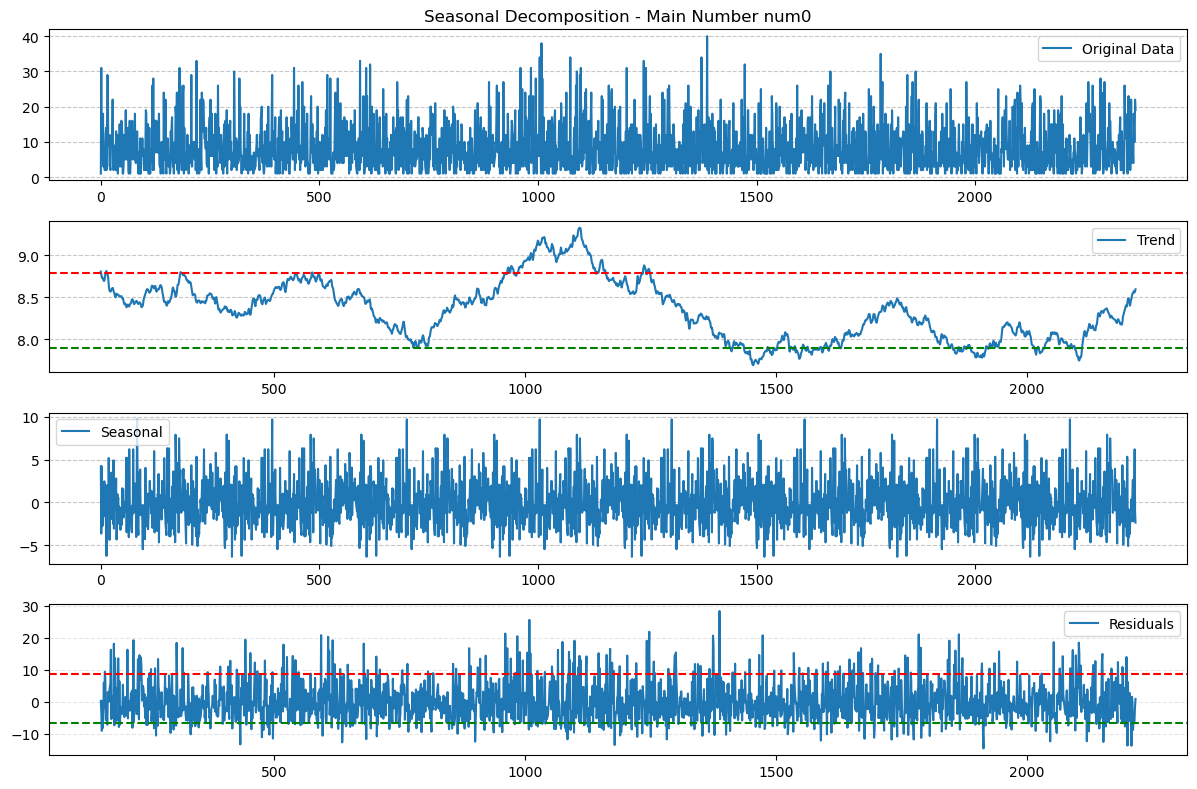

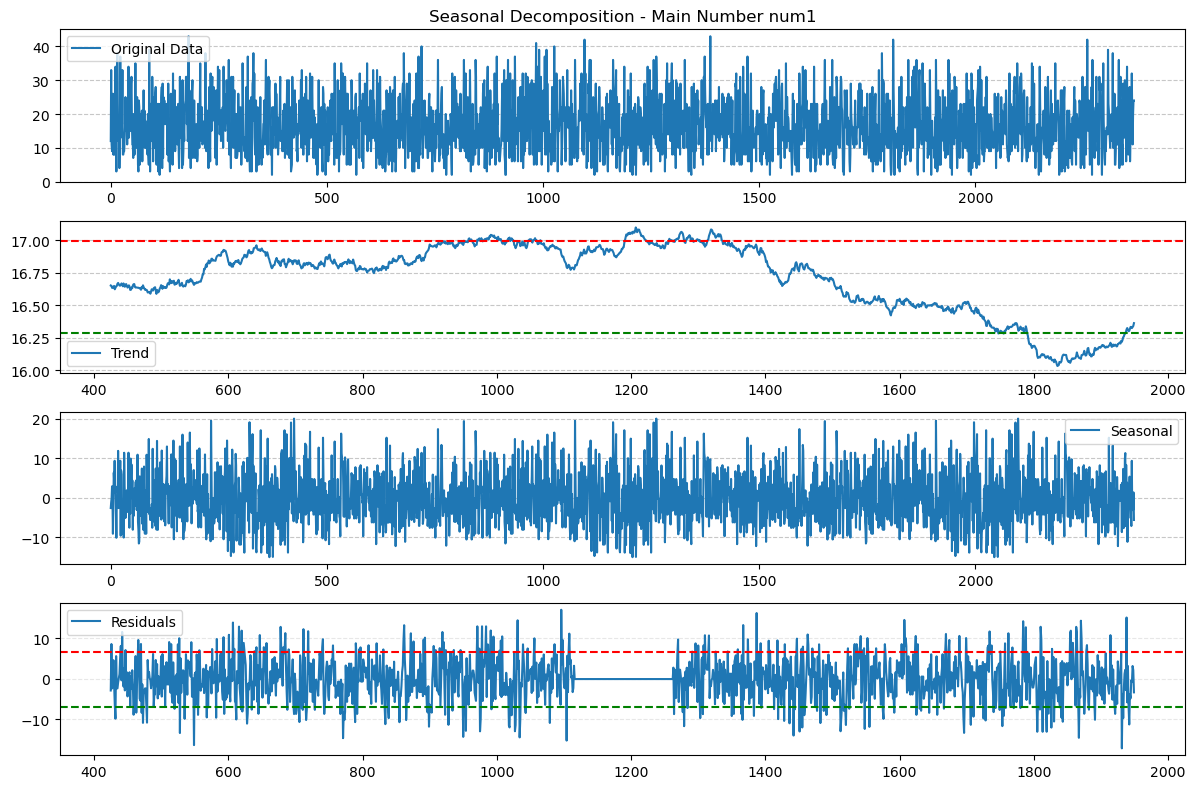

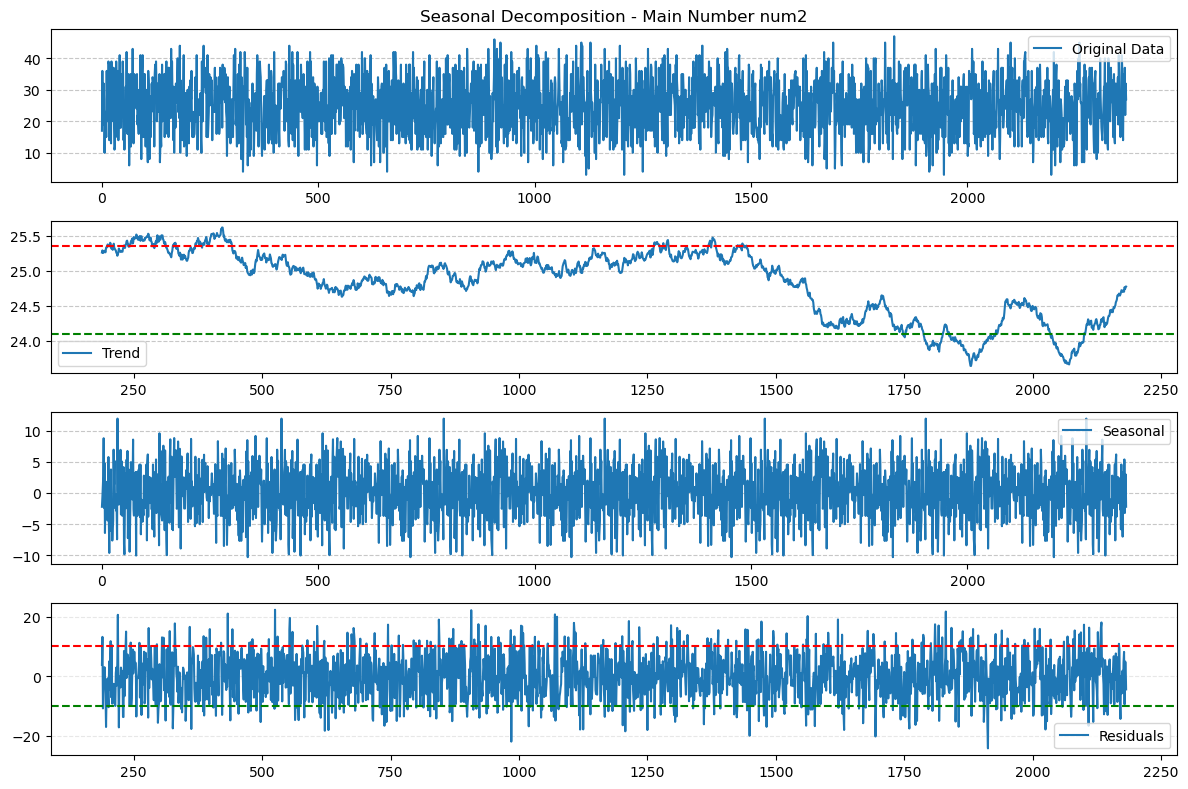

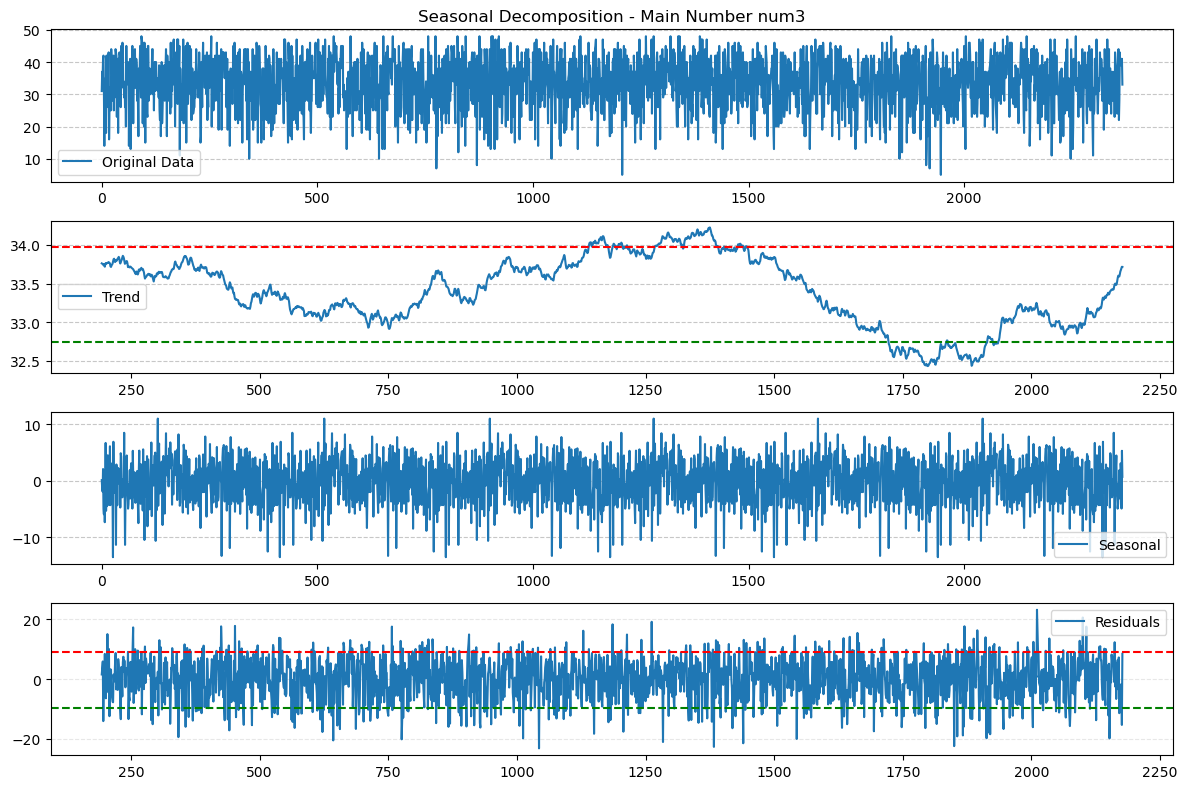

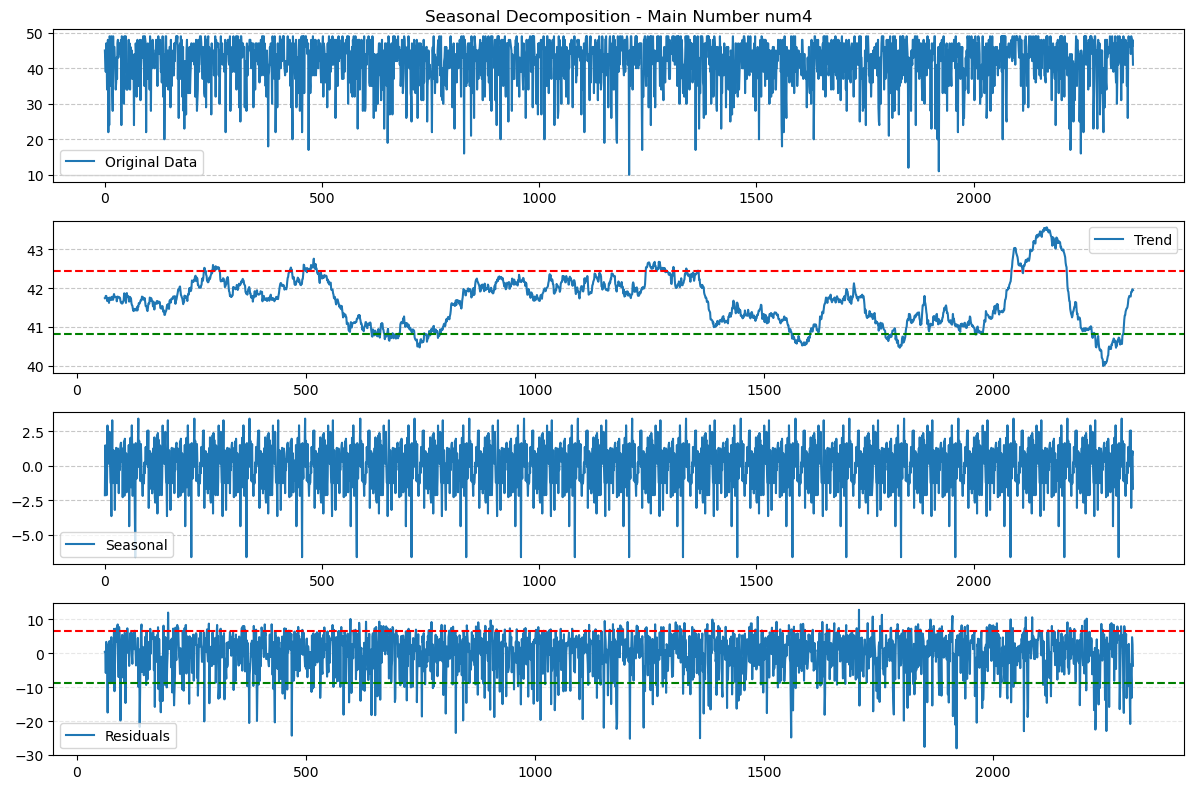

In [9]:

seasonal_decomposition_for_each_main_number(historical_data, seasonality_periods)


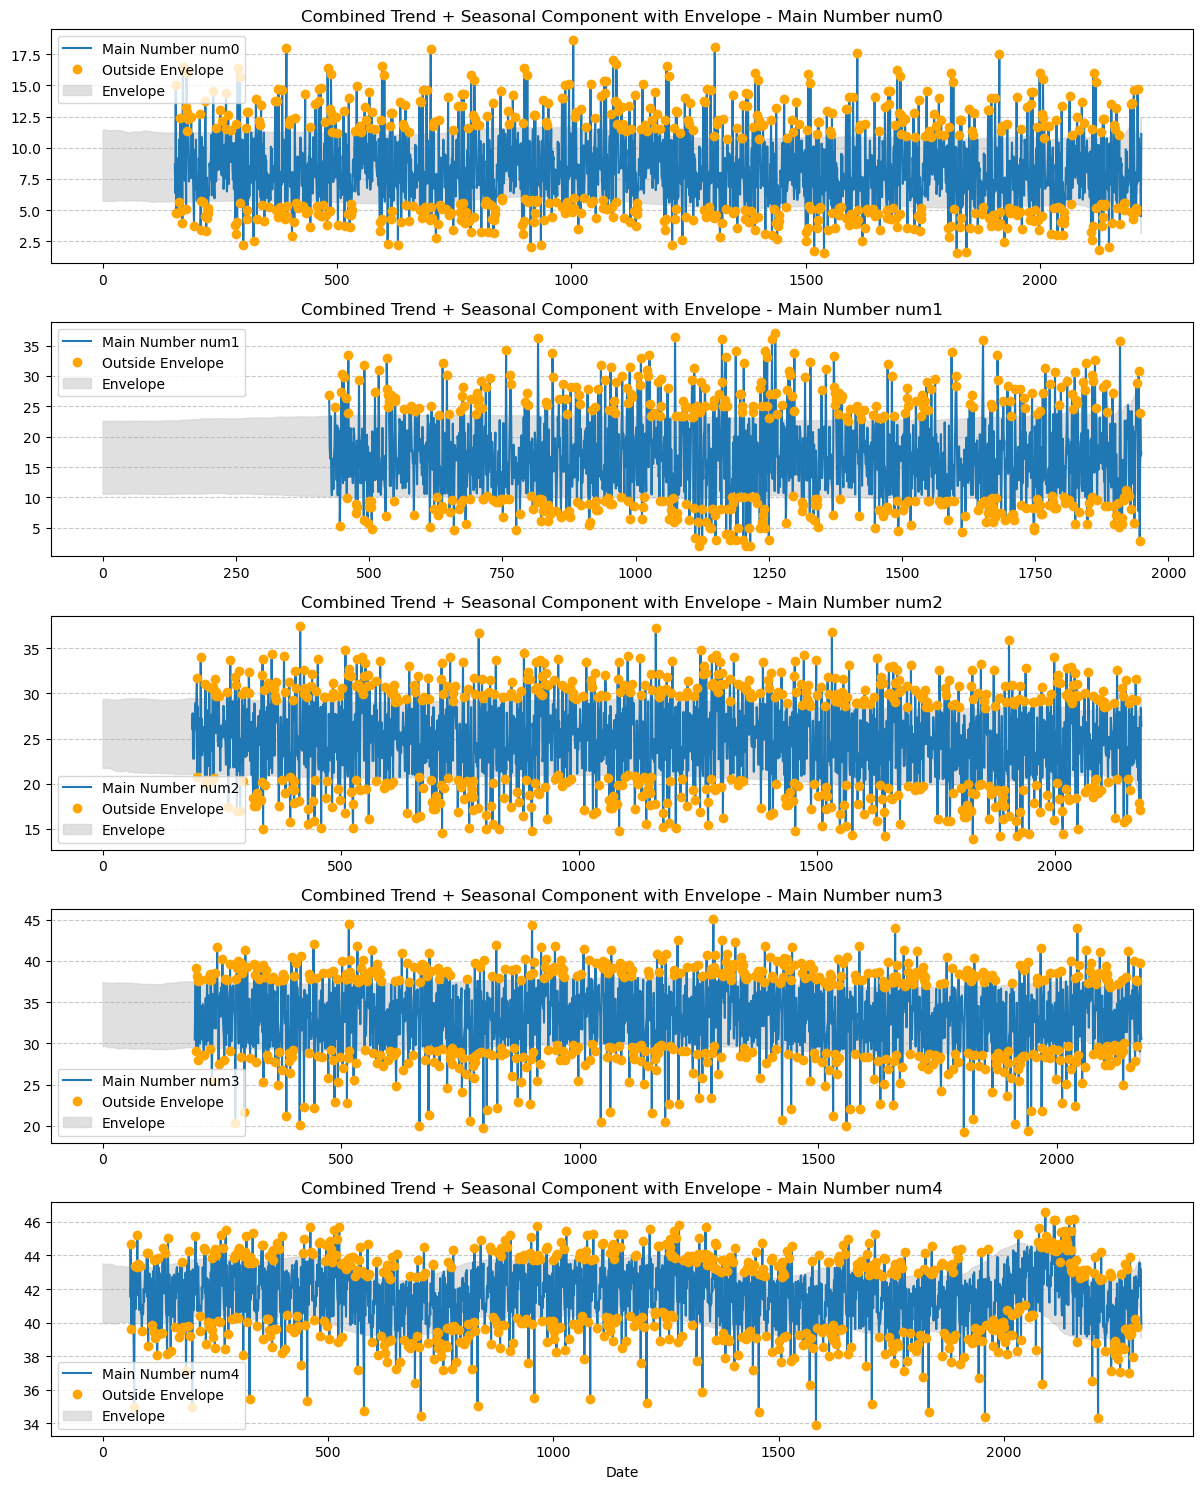

In [10]:

def plot_combined_trend_plus_seasonal_with_envelope(historical_data, seasonality_periods):
    """
    Plots the combined trend + seasonal component for each main number and the chance number with the envelope.

    Parameters:
        historical_data (pd.DataFrame): DataFrame containing historical lottery data.
        seasonality_periods (dict): Dictionary containing seasonality periods for each main number.
    """
    main_numbers = historical_data.iloc[:, :-1]

    plt.figure(figsize=(12, 15))

    for i, column in enumerate(main_numbers.columns):
        period = seasonality_periods[column]
        decomposition = seasonal_decomposition(main_numbers[column], period=period)
        trend_plus_seasonal = decomposition.trend + decomposition.seasonal

        # Calculate the upper and lower bounds of the envelope
        rolling_mean = trend_plus_seasonal.rolling(window=period, min_periods=1).mean()
        rolling_std = trend_plus_seasonal.rolling(window=period, min_periods=1).std()
        upper_bound = rolling_mean + 1 * rolling_std
        lower_bound = rolling_mean - 1 * rolling_std

        plt.subplot(5, 1, i + 1)
        plt.plot(main_numbers.index, trend_plus_seasonal, label=f"Main Number {column}")

        # Detect values outside the envelope and plot them in orange
        outside_envelope = (trend_plus_seasonal > upper_bound) | (trend_plus_seasonal < lower_bound)
        plt.plot(main_numbers.index[outside_envelope], trend_plus_seasonal[outside_envelope], 'o', color='orange', label='Outside Envelope')

        plt.fill_between(main_numbers.index, lower_bound, upper_bound, color='lightgray', alpha=0.7, label='Envelope')

        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.title(f"Combined Trend + Seasonal Component with Envelope - Main Number {column}")

    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()
            
# Assuming you already have 'seasonality_periods' calculated using detect_seasonality_period_for_each_column
plot_combined_trend_plus_seasonal_with_envelope(historical_data, seasonality_periods)

Main Number num0: 299 data points outside the envelope.
Main Number num1: 192 data points outside the envelope.
Main Number num2: 288 data points outside the envelope.
Main Number num3: 227 data points outside the envelope.
Main Number num4: 251 data points outside the envelope.


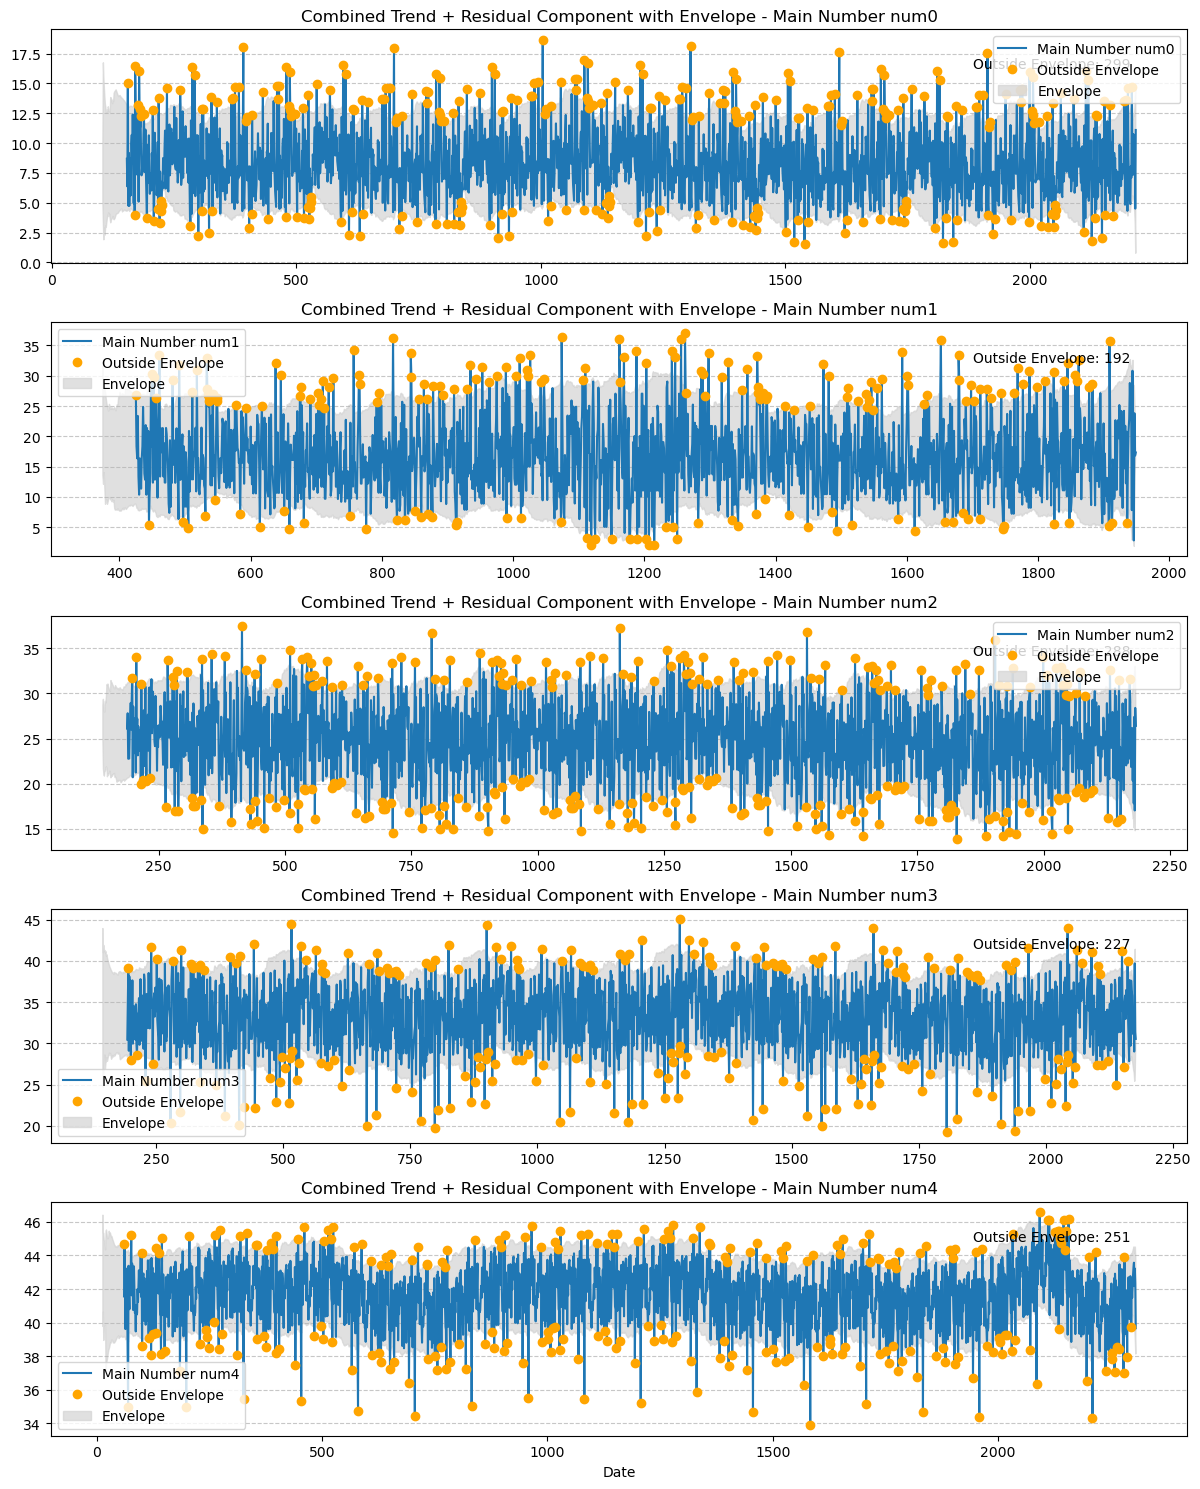

In [13]:
def plot_combined_trend_plus_residual_with_envelope(historical_data, seasonality_periods, std_deviation):
    """
    Plots the combined trend + residual component for each main number and the chance number with the envelope.
    Also counts the number of data points outside the envelope for each main number.

    Parameters:
        historical_data (pd.DataFrame): DataFrame containing historical lottery data.
        seasonality_periods (dict): Dictionary containing seasonality periods for each main number.
    """
    main_numbers = historical_data.iloc[:, :-1]

    plt.figure(figsize=(12, 15))

    for i, column in enumerate(main_numbers.columns):
        period = seasonality_periods[column]
        decomposition = seasonal_decomposition(main_numbers[column], period=period)
        trend_plus_resid = decomposition.trend + decomposition.seasonal 

        # Calculate the upper and lower bounds of the envelope
        rolling_mean = trend_plus_resid.rolling(window=50, min_periods=1).mean()
        rolling_std = trend_plus_resid.rolling(window=50, min_periods=1).std()
        upper_bound = rolling_mean + std_deviation * rolling_std
        lower_bound = rolling_mean - std_deviation * rolling_std

        plt.subplot(5, 1, i + 1)
        plt.plot(main_numbers.index, trend_plus_resid, label=f"Main Number {column}")

        # Detect values outside the envelope and plot them in orange
        outside_envelope = (trend_plus_resid > upper_bound) | (trend_plus_resid < lower_bound)
        plt.plot(main_numbers.index[outside_envelope], trend_plus_resid[outside_envelope], 'o', color='orange', label='Outside Envelope')

        # Count the number of data points outside the envelope
        num_outside_envelope = outside_envelope.sum()
        plt.text(0.95, 0.85, f"Outside Envelope: {num_outside_envelope}", ha='right', va='center', transform=plt.gca().transAxes)

        plt.fill_between(main_numbers.index, lower_bound, upper_bound, color='lightgray', alpha=0.7, label='Envelope')

        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.title(f"Combined Trend + Residual Component with Envelope - Main Number {column}")
        
        # Print the count of data points outside the envelope for each main number
        print(f"Main Number {column}: {num_outside_envelope} data points outside the envelope.")


    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()
            
# Assuming you already have 'seasonality_periods' calculated using detect_seasonality_period_for_each_column
plot_combined_trend_plus_residual_with_envelope(historical_data, seasonality_periods, 1.5)